Imports


In [1]:
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
import numpy as np
import gensim
from gensim.models import Word2Vec
import tensorflow.keras as keras
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import tensorflow as tf
import nltk
nltk.download('stopwords')
import re
from sklearn.model_selection import train_test_split
from keras.layers import SimpleRNN
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


DataSets Merging

In [2]:
train_dataset = pd.read_csv("spam_ham_dataset.csv")
test_dataset = pd.read_csv("messages.csv",encoding='latin-1')
dataset_Assas = pd.read_csv("completeSpamAssassin.csv",encoding="latin-1")
dataset = pd.read_csv("spam_emails.csv",encoding="latin-1")

X_TEST = list(dataset["v2"])
Y_TEST = [1 if i=="spam" else 0 for i in dataset["v1"]]

Y4 = list(dataset_Assas['Label'])
X4 = list(dataset_Assas['Body'])


Y2 = list(train_dataset['label_num'])
X2 = list(train_dataset['text'])

Y1 = list(test_dataset["label"])
X1 = list(test_dataset["message"])
X3 = X1+X2+X4+X_TEST
X3 = pd.Series(X3)
Y3 = Y1+Y2+Y4+Y_TEST
Y3 = pd.Series(Y3)
print(X3.shape,pd.Series(X1).shape,pd.Series(X2).shape)
print(Y3.shape,pd.Series(Y1).shape,pd.Series(Y2).shape)

(19682,) (2893,) (5171,)
(19682,) (2893,) (5171,)


Data Cleaning (preprocessing)


In [3]:


text_cleaning_re = "@\S+|https?:\S+|http?:\S+|[^A-Za-z0-9]:\S+|subject:\S+|nbsp"
def preprocess(text, stem=False):
    stemmer = PorterStemmer()
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)


stop_words = stopwords.words('english')



#Data Preprocessing: (word stem)

X3 = X3.apply(lambda x: preprocess(x,True))


#Wor2vec part/ tokenization
tokenizer = Tokenizer()

tokenizer.fit_on_texts(X3)


word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1000
# print("Vocabulary Size :", vocab_size)

X3.head().reset_index()
Y3.head().reset_index()

X3 = pad_sequences(tokenizer.texts_to_sequences(X3),maxlen = 50)


print(X3.shape,Y3.shape)


(19682, 50) (19682,)


Splitting of the dataset


In [4]:
x_train, x_test, y_train, y_test = train_test_split(X3, Y3, test_size=0.3, random_state=0)

x_train, x_train2, y_train, y_train2 = train_test_split(x_train, y_train, test_size=0.5, random_state=0,shuffle=True)


Model Training -LSTM-

In [5]:

MAX_SEQUENCE_LENGTH = 50
n_lstm = 200
drop_lstm = 0.2
embeding_dim = 16
drop_value = 0.2
n_dense = 24
num_epochs = 7
early_stop = EarlyStopping(monitor='val_loss', patience=3)
#LSTM Spam detection architecture
model1 = Sequential()
model1.add(Embedding(vocab_size, embeding_dim, input_length=MAX_SEQUENCE_LENGTH))
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model1.add(Dropout(0.1))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
# model1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'],validation_data=(x_valid,y_valid))
print(x_train.shape)

history = model1.fit(x_train, y_train, epochs=num_epochs, verbose=2)
early_stop = EarlyStopping(monitor='accuracy', patience=2)


(6888, 50)
Epoch 1/7
216/216 - 55s - loss: 0.4330 - accuracy: 0.8257 - 55s/epoch - 255ms/step
Epoch 2/7
216/216 - 51s - loss: 0.2661 - accuracy: 0.9008 - 51s/epoch - 237ms/step
Epoch 3/7
216/216 - 51s - loss: 0.2197 - accuracy: 0.9169 - 51s/epoch - 236ms/step
Epoch 4/7
216/216 - 51s - loss: 0.2052 - accuracy: 0.9221 - 51s/epoch - 237ms/step
Epoch 5/7
216/216 - 51s - loss: 0.2181 - accuracy: 0.9201 - 51s/epoch - 236ms/step
Epoch 6/7
216/216 - 51s - loss: 0.1988 - accuracy: 0.9237 - 51s/epoch - 237ms/step
Epoch 7/7
216/216 - 51s - loss: 0.1918 - accuracy: 0.9260 - 51s/epoch - 238ms/step


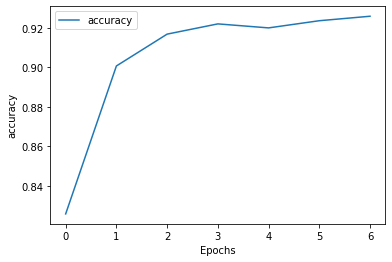

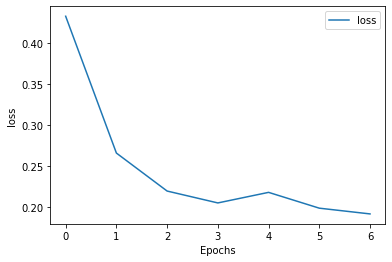

In [6]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Training of the model 5 -Bi LSTM-


In [7]:
BiLSTM = Sequential()
BiLSTM.add(Embedding(vocab_size, embeding_dim, input_length=MAX_SEQUENCE_LENGTH))
BiLSTM.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True)))
BiLSTM.add(Dense(1, activation='sigmoid'))
BiLSTM.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
# Training
num_epochs = 5
early_stop = EarlyStopping(monitor='accuracy', patience=2)
history = BiLSTM.fit(x_train, y_train, epochs=num_epochs, 
                    callbacks =[early_stop], verbose=2)

Epoch 1/5
216/216 - 41s - loss: 0.3438 - accuracy: 0.8652 - 41s/epoch - 189ms/step
Epoch 2/5
216/216 - 37s - loss: 0.1016 - accuracy: 0.9636 - 37s/epoch - 173ms/step
Epoch 3/5
216/216 - 37s - loss: 0.0662 - accuracy: 0.9769 - 37s/epoch - 173ms/step
Epoch 4/5
216/216 - 37s - loss: 0.0440 - accuracy: 0.9834 - 37s/epoch - 173ms/step
Epoch 5/5
216/216 - 37s - loss: 0.0435 - accuracy: 0.9833 - 37s/epoch - 172ms/step


Training of Model 2 -RNN-

In [8]:
rnn = Sequential()
rnn.add(SimpleRNN(128, activation='relu', input_dim=50 , return_sequences = True))
rnn.add(SimpleRNN(64, activation='relu' ,  return_sequences = False))
# Adding dropout to prevent overfitting
#rnn.add(Dropout(0.1))
rnn.add(Dense(1, activation='sigmoid'))
rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

x_train2 = x_train2.reshape(len(y_train2),1,50)
y_train2 = np.array(y_train2).reshape(len(y_train2),1,1)
rnn.fit(x_train2, y_train2, batch_size=100, epochs=150)

Epoch 1/150
69/69 [==============================] - 2s 3ms/step - loss: 667.8979 - accuracy: 0.6114
Epoch 2/150
69/69 [==============================] - 0s 3ms/step - loss: 272.9192 - accuracy: 0.6513
Epoch 3/150
69/69 [==============================] - 0s 3ms/step - loss: 172.0852 - accuracy: 0.6828
Epoch 4/150
69/69 [==============================] - 0s 3ms/step - loss: 120.1629 - accuracy: 0.7058
Epoch 5/150
69/69 [==============================] - 0s 3ms/step - loss: 92.9794 - accuracy: 0.7185
Epoch 6/150
69/69 [==============================] - 0s 3ms/step - loss: 70.3450 - accuracy: 0.7399
Epoch 7/150
69/69 [==============================] - 0s 3ms/step - loss: 54.2758 - accuracy: 0.7561
Epoch 8/150
69/69 [==============================] - 0s 3ms/step - loss: 48.0927 - accuracy: 0.7644
Epoch 9/150
69/69 [==============================] - 0s 3ms/step - loss: 38.1921 - accuracy: 0.7786
Epoch 10/150
69/69 [==============================] - 0s 3ms/step - loss: 35.5383 - accuracy: 0.

Training of Model 3 -MNNB-

In [9]:
# Create the model with the best hyperparameters

parameters = {"alpha": [0.2,1,2,5,10], "fit_prior": [True, False]}

grid = GridSearchCV(MultinomialNB(), param_grid=parameters)
grid.fit(x_train,y_train)

# Create a DataFrame with the best Hyperparameters
pd.DataFrame(grid.cv_results_)[['params','mean_test_score']]\
                               .sort_values(by="mean_test_score", ascending=False)
grid.best_params_
alpha, fit_prior = grid.best_params_['alpha'], grid.best_params_['fit_prior']
model = MultinomialNB(alpha = alpha)

model.fit(x_train,y_train)
# y_pred = model.predict(X_test)

#

MultinomialNB(alpha=0.2)

Training of Model 4 -XGBoost-

In [10]:
xgb = XGBClassifier()
xgb.fit(x_train, y_train)


XGBClassifier()

Training of Model 6 -NB-

In [11]:

gnb = GaussianNB()
gnb.fit(x_train, y_train)
# print(classification_report(y_test, y_pred))
# print(confusion_matrix(y_test, y_pred))
# print(accuracy_score(y_test, y_pred)) 

GaussianNB()

Training of Model 7 -KNN-

In [12]:


neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(x_train,y_train)


KNeighborsClassifier()

In [13]:






# model1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'],validation_data=(x_test,y_test))
y1 = model1.predict(x_test)
var1=(y1>0.5)
x_test1 = x_test.reshape(len(y_test),1,50)

y2 = rnn.predict(x_test1)
var2=(y2>0.5)

y3 = model.predict(x_test)
var3=(y3>0.5)

y4 = xgb.predict(x_test)
var4 = (y4>0.5)

y5 = BiLSTM.predict(x_test)
var5 = (y5>0.5)

y6 = gnb.predict(x_test)
var6 = (y6>0.5)

y7 = neigh.predict(x_test)
var7 = (y7>0.5)

In [14]:
y_gnb = gnb.predict(x_test)
var_gnb = (y_gnb>0.5)
print(accuracy_score(var_gnb,y_test))

0.6883996613039797


phase de Test

In [15]:



cpt = 0
tot = len(var1)
print(y1.shape)

y_test = list(y_test)

for i in range(len(var1)):
  if list(var1[i]).count([y_test[i]])/50 > 0.10 :
    cpt += list(var1[i]).count([y_test[i]])/50 > 0.50 
  
  # print(var1[i][0])
print("LSTM: ", cpt/tot)

cpt = 0
tot = len(var5)
print(y5.shape)


for i in range(len(var5)):
  if list(var5[i]).count([y_test[i]])/50 > 0.10 :
    cpt += list(var5[i]).count([y_test[i]])/50 > 0.50 
  
  # print(var1[i][0])
print("BiLSTM: ", cpt/tot)

cpt = 0
tot = len(var2)
print(y2.shape)

for i in range(len(var2)):
  if var2[i][0] == y_test[i] :
    cpt += 1
  
  # print(var1[i][0])
print("RNN: ", cpt/tot)


cpt = 0
tot = len(var3)
print(y3.shape)
for i in range(len(var3)):
  if var3[i] == y_test[i] :
    cpt += 1
  # print(var1[i][0])
print("MNB: ", cpt/tot)

cpt = 0
tot = len(var4)
print(y4.shape)
for i in range(len(var4)):
  if var4[i] == y_test[i] :
    cpt += 1
  # print(var1[i][0])
print("XGBoost: ", cpt/tot)

cpt = 0
tot = len(var6)
print(y6.shape)
for i in range(len(var6)):
  if var6[i] == y_test[i] :
    cpt += 1
  # print(var1[i][0])
print("GNB: ", cpt/tot)

cpt = 0
tot = len(var7)
print(y7.shape)
for i in range(len(var7)):
  if var7[i] == y_test[i] :
    cpt += 1
  # print(var1[i][0])
print("KNN: ", cpt/tot)

EL_cpt = 0
FP = 0
FN = 0
result = []
for i in range(len(y_test)):
  el = [y_test[i] if list(var1[i]).count([y_test[i]])/50 > 0.50 else not y_test[i],var7[i],y_test[i] if list(var5[i]).count([y_test[i]])/50 > 0.50 else not y_test[i]]

  if(el.count(y_test[i]) >= 2):
    EL_cpt += 1
    result.append(y_test[i])
  else:
    result.append(not y_test[i])
  if(el.count(False) >= 2 and y_test[i]): FN +=1
  if(el.count(True) >= 2 and  not y_test[i]): FP +=1
print("EL: ",EL_cpt/tot)
print("EL False Negative: ",FN/tot)
print("EL: False Positive",FP/tot)

print(classification_report(result, y_test))
print(accuracy_score(result, y_test))



(5905, 50, 1)
LSTM:  0.8658763759525826
(5905, 50, 1)
BiLSTM:  0.9429297205757833
(5905, 1)
RNN:  0.7302286198137172
(5905,)
MNB:  0.463844199830652
(5905,)
XGBoost:  0.8059271803556308
(5905,)
GNB:  0.6883996613039797
(5905,)
KNN:  0.7712108382726502
EL:  0.8877222692633362
EL False Negative:  0.10059271803556308
EL: False Positive 0.011685012701100762
              precision    recall  f1-score   support

           0       0.98      0.88      0.93      5014
           1       0.58      0.92      0.71       891

    accuracy                           0.89      5905
   macro avg       0.78      0.90      0.82      5905
weighted avg       0.92      0.89      0.90      5905

0.8877222692633362


In [16]:

print(X_TEST[6],Y_TEST[6])

Even my brother is not like to speak with me. They treat me like aids patent. 0


Test Function Defenition

In [17]:
def Ensemble_Predict(x):
  xgboost = list(xgb.predict(x))
  blstm = BiLSTM.predict(x)
  lstm = model1.predict(x)
  knn = list(neigh.predict(x))
  NB = list(gnb.predict(x)) 
  ys = []
  y_lstm = []
  for i in lstm:
    y_lstm.append(list(i).count([True])/len(i))
  y_lstm = sum(y_lstm)/len(y_lstm)
  ys.append(y_lstm)
  y_blstm = []
  for i in blstm:
    if(list(i).count([True]) > len(i)): y_blstm.append(True)
    else: y_blstm.append(False)
  y_bilstm = y_blstm.count(True)/len(y_blstm)
  ys.append(y_bilstm)
  knn = knn.count(True)/len(knn)
  ys.append(knn)
  xgboost = xgboost.count(True)/len(xgboost)
  NB = NB.count(True)/len(NB)
  ys.append(xgboost)
  ys.append(NB)
  print(ys)
  if(sum(ys)/5 > 0.5): return True
  return False
  
  

def predict_email(email):
  e = preprocess(email)
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(e)

  word_index = tokenizer.word_index
  vocab_size = len(tokenizer.word_index)


  x = pad_sequences(tokenizer.texts_to_sequences(e),maxlen = 50)
  return Ensemble_Predict(x)


Custom Test

In [18]:
import os
for filename in os.listdir("./easy_ham"):
   with open(os.path.join("./easy_ham", filename), 'r') as f: 
     email = f.read()
     print(predict_email(email))
  

FileNotFoundError: ignored

In [ ]:
for filename in os.listdir("./spam"):
  try:
    with open(os.path.join("./spam", filename), 'r') as f: 
      print(filename)
      email = f.read()
      print(predict_email(email))
  except:
    pass

In [ ]:
datasettt = pd.read_csv("spam_ham_dataset.csv")

xxx = datasettt["text"]
xxx.apply(lambda x:preprocess(x,True))
tokenizer = Tokenizer()
tokenizer.fit_on_texts(xxx)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index)


xxx = pad_sequences(tokenizer.texts_to_sequences(xxx),maxlen = 50)
yyyy = xgb.predict(xxx)

In [ ]:
print(yyyy)
yyy = datasettt["label_num"]
print(accuracy_score(yyyy,yyy))